<a href="https://colab.research.google.com/github/Abubakrhegazi/Arabic-Grammar-AutoCorrection/blob/main/Arabic_Error_Detection_Edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import math
import re

In [ ]:
#functions dictionary
def smart_open(fname, mode = 'r'):
    if fname.endswith('.gz'):
        import gzip
        # Using max compression (9) by default seems to be slow.
        # Let's try using the fastest.
        return gzip.open(fname, mode, 1)
    else:
        return open(fname, mode)

def tokanizer(list):
  tokens =[]
  for s in list:
      for i in s:
          tokens.append(i.split(' '))
  return tokens

def randint(b, a=0):
    return random.randint(a,b)

def uniq(seq, idfun=None):
    # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

def sort_dict(myDict, byValue=False, reverse=False):
    if byValue:
        items = myDict.items()
        items.sort(key = operator.itemgetter(1), reverse=reverse)
    else:
        items = sorted(myDict.items())
    return items

def max_dict(myDict, byValue=False):
    if byValue:
        skey=lambda x:x[1]
    else:
        skey=lambda x:x[0]
    return max(myDict.items(), key=skey)


def min_dict(myDict, byValue=False):
    if byValue:
        skey=lambda x:x[1]
    else:
        skey=lambda x:x[0]
    return min(myDict.items(), key=skey)

def paragraphs(lines, is_separator=lambda x : x == '\n', joiner=''.join):
    paragraph = []
    for line in lines:
        if is_separator(line):
            if paragraph:
                yield joiner(paragraph)
                paragraph = []
        else:
            paragraph.append(line)
    if paragraph:
        yield joiner(paragraph)

def isASCII(word):
    try:
        word = word.decode("ascii")
        return True
    except UnicodeEncodeError :
        return False
    except UnicodeDecodeError:
        return False


def intersect(x, y):
    return [z for z in x if z in y]

# Mapping Windows CP1252 Gremlins to Unicode
# from http://effbot.org/zone/unicode-gremlins.htm
cp1252 = {
    # from http://www.microsoft.com/typography/unicode/1252.htm
    u"\x80": u"\u20AC", # EURO SIGN
    u"\x82": u"\u201A", # SINGLE LOW-9 QUOTATION MARK
    u"\x83": u"\u0192", # LATIN SMALL LETTER F WITH HOOK
    u"\x84": u"\u201E", # DOUBLE LOW-9 QUOTATION MARK
    u"\x85": u"\u2026", # HORIZONTAL ELLIPSIS
    u"\x86": u"\u2020", # DAGGER
    u"\x87": u"\u2021", # DOUBLE DAGGER
    u"\x88": u"\u02C6", # MODIFIER LETTER CIRCUMFLEX ACCENT
    u"\x89": u"\u2030", # PER MILLE SIGN
    u"\x8A": u"\u0160", # LATIN CAPITAL LETTER S WITH CARON
    u"\x8B": u"\u2039", # SINGLE LEFT-POINTING ANGLE QUOTATION MARK
    u"\x8C": u"\u0152", # LATIN CAPITAL LIGATURE OE
    u"\x8E": u"\u017D", # LATIN CAPITAL LETTER Z WITH CARON
    u"\x91": u"\u2018", # LEFT SINGLE QUOTATION MARK
    u"\x92": u"\u2019", # RIGHT SINGLE QUOTATION MARK
    u"\x93": u"\u201C", # LEFT DOUBLE QUOTATION MARK
    u"\x94": u"\u201D", # RIGHT DOUBLE QUOTATION MARK
    u"\x95": u"\u2022", # BULLET
    u"\x96": u"\u2013", # EN DASH
    u"\x97": u"\u2014", # EM DASH
    u"\x98": u"\u02DC", # SMALL TILDE
    u"\x99": u"\u2122", # TRADE MARK SIGN
    u"\x9A": u"\u0161", # LATIN SMALL LETTER S WITH CARON
    u"\x9B": u"\u203A", # SINGLE RIGHT-POINTING ANGLE QUOTATION MARK
    u"\x9C": u"\u0153", # LATIN SMALL LIGATURE OE
    u"\x9E": u"\u017E", # LATIN SMALL LETTER Z WITH CARON
    u"\x9F": u"\u0178", # LATIN CAPITAL LETTER Y WITH DIAERESIS
}

def fix_cp1252codes(text):
    # map cp1252 gremlins to real unicode characters
    if re.search(u"[\x80-\x9f]", text):
        def fixup(m):
            s = m.group(0)
            return cp1252.get(s, s)
        if isinstance(text, type("")):
            # make sure we have a unicode string
            text = unicode(text, "iso-8859-1")
        text = re.sub(u"[\x80-\x9f]", fixup, text)
    return text

def clean_utf8(text):
    return filter(lambda x : x > '\x1f' and x < '\x7f', text)

def pairs(iterable, overlapping=False):
    iterator = iterable.__iter__()
    token = iterator.next()
    i = 0
    for lookahead in iterator:
        if overlapping or i % 2 == 0:
            yield (token, lookahead)
        token = lookahead
        i += 1
    if i % 2 == 0:
        yield (token, None)

def frange(start, end=None, inc=None):
    "A range function, that does accept float increments..."

    if end == None:
        end = start + 0.0
        start = 0.0

    if inc == None:
        inc = 1.0

    L = []
    while 1:
        next = start + len(L) * inc
        if inc > 0 and next >= end:
            break
        elif inc < 0 and next <= end:
            break
        L.append(next)

    return L

def softmax(values):
    a = max(values)
    Z = 0.0
    for v in values:
        Z += math.exp(v - a)
    sm = [math.exp(v-a) / Z for v in values]
    return sm

In [ ]:
import sys
from getopt import getopt

def load_annotation(gold_file):
    source_sentences = []
    gold_edits = []
    fgold = smart_open(gold_file, 'r')
    puffer = fgold.read()
    fgold.close()
    #puffer = puffer.decode('utf8')
    for item in paragraphs(puffer.splitlines(True)):
        item = item.splitlines(False)
        sentence = [line[2:].strip() for line in item if line.startswith('S ')]
        assert sentence != []
        annotations = {}
        for line in item[1:]:
            if line.startswith('I ') or line.startswith('S '):
                continue
            assert line.startswith('A ')
            line = line[2:]
            fields = line.split('|||')
            start_offset = int(fields[0].split()[0])
            end_offset = int(fields[0].split()[1])
            etype = fields[1]
            if etype == 'noop':
                start_offset = -1
                end_offset = -1
            corrections =  [c.strip() if c != '-NONE-' else '' for c in fields[2].split('||')]
            # NOTE: start and end are *token* offsets
            original = ' '.join(' '.join(sentence).split()[start_offset:end_offset])
            if len(fields) > 4:
                annotator = int(fields[5])
            else:
                annotator = 0  # default if missing
            if annotator not in annotations:
                annotations[annotator] = []
            annotations[annotator].append((start_offset, end_offset, original, corrections, etype))

        tok_offset = 0
        for this_sentence in sentence:
            tok_offset += len(this_sentence.split())
            source_sentences.append(this_sentence)
            this_edits = {}
            for annotator, annotation in annotations.items():
                this_edits[annotator] = [edit for edit in annotation if edit[0] <= tok_offset and edit[1] <= tok_offset and edit[0] >= 0 and edit[1] >= 0]
            if len(this_edits) == 0:
                this_edits[0] = []
            gold_edits.append(this_edits)
    return (source_sentences, gold_edits)

# **Train Data Preprocessing**

In [ ]:
sentences=[]
edits=[]

sentences.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Train2014.m2')[0])
edits.append(load_annotation('/content/drive/MyDrive/Grammar/QALB-Train2014.m2')[1])


In [ ]:
import pandas as pd

# Combine the lists of sentences and edits into a list of dictionaries
data_list = []
for sent_text, edit_dict in zip(sentences[0], edits[0]):
    data_list.append({'sentence': sent_text, 'edits': edit_dict})

# Create a DataFrame
df = pd.DataFrame(data_list)

# Function to apply edits and produce a corrected sentence
def apply_edits(sentence, edits_dict):
    tokens = sentence.split()

    if not edits_dict or 0 not in edits_dict:
        return sentence  # No edits

    edits = edits_dict[0]  # Use annotator 0
    for start, end, _, correction, _ in sorted(edits, key=lambda x: x[0], reverse=True):
        tokens = tokens[:start] + correction + tokens[end:]

    return ' '.join(tokens)


# Apply the edits
df['corrected'] = df.apply(lambda row: apply_edits(row['sentence'], row['edits']), axis=1)

# Optional: Filter out unchanged sentences
# df = df[df['sentence'] != df['corrected']]

# Print example
print(df[['sentence', 'corrected']].head())
print("\nDataFrame shape:", df.shape)


                                            sentence  \
0  الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...   
1  نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...   
2  للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...   
3  واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...   
4  يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...   

                                           corrected  
0  إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...  
1  نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...  
2  للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...  
3  واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...  
4  يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...  

DataFrame shape: (19411, 3)


In [ ]:
df.head(11)

,sentence,edits,corrected
0,الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...,"{0: [(0, 1, 'الى', ['إلى'], 'Edit'), (4, 4, ''...",إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...
1,نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...,"{0: [(2, 3, 'الاسى', ['الأسى'], 'Edit'), (6, 7...",نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...
2,للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...,"{0: [(0, 1, 'للاسف', ['للأسف'], 'Edit'), (1, 2...",للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...
3,واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...,"{0: [(2, 3, 'أنتصاراتهم', ['انتصاراتهم'], 'Edi...",واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...
4,يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...,"{0: [(3, 4, 'ما', ['من'], 'Edit'), (4, 5, 'يدع...",يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...
5,اليوم المظاهرات الحاشدة تعتبر جمعة مفصلية تاري...,"{0: [(7, 7, '', ['،'], 'Add_before'), (10, 11,...",اليوم المظاهرات الحاشدة تعتبر جمعة مفصلية تاري...
6,وقف اطلاق الصواريخ من غزة مقابل رفع الحصار عن ...,"{0: [(1, 2, 'اطلاق', ['إطلاق'], 'Edit'), (12, ...",وقف إطلاق الصواريخ من غزة مقابل رفع الحصار عن ...
7,"إلى الإخوة في الجزيرة , هؤلاء شهداء وهم خيرة ا...","{0: [(4, 5, ',', [':'], 'Edit'), (7, 7, '', ['...",إلى الإخوة في الجزيرة : هؤلاء شهداء ، وهم خيرة...
8,مصير جميع الإرهابيين السحق على يد الجيش التركي...,"{0: [(8, 8, '', ['.'], 'Add_before'), (11, 12,...",مصير جميع الإرهابيين السحق على يد الجيش التركي...
9,ثورة الآخرين على ارض الشام حيث ان الجيش الحر ي...,"{0: [(3, 4, 'ارض', ['أرض'], 'Edit'), (5, 5, ''...",ثورة الآخرين على أرض الشام ، حيث أن الجيش الحر...


In [ ]:
df = df.rename(columns={
    'sentence': 'input',
    'edits': 'edits',
    'corrected': 'target'
})
df['edit_count'] = df['edits'].apply(lambda e: len(e.get(0, [])))
df['edit_types'] = df['edits'].apply(
    lambda e: [et[4] for et in e.get(0, [])] if len(e.get(0, [])) > 0 and len(e.get(0, [])[0]) > 4 else []
)
df['edit_types'] = df['edits'].apply(lambda e: [et[4] for et in e.get(0, [])])

df.head()

,input,edits,target,edit_count,edit_types
0,الى التعليق رقم 2 اكيد ان لحكام العرب والمسلمي...,"{0: [(0, 1, 'الى', ['إلى'], 'Edit'), (4, 4, ''...",إلى التعليق رقم 2 أكيد اكيد أن للحكام العرب وا...,14,"[Edit, Add_before, Edit, Edit, Edit, Edit, Edi..."
1,نحن ببالغ الاسى نعزي ضحايا الحادث الاليم الذي ...,"{0: [(2, 3, 'الاسى', ['الأسى'], 'Edit'), (6, 7...",نحن ببالغ الأسى نعزي ضحايا الحادث الأليم الذي ...,16,"[Edit, Edit, Add_before, Edit, Edit, Add_befor..."
2,للاسف ان الدم المهدور عراقي لكن بشكل عام لماذا...,"{0: [(0, 1, 'للاسف', ['للأسف'], 'Edit'), (1, 2...",للأسف إن الدم المهدور عراقي ، لكن بشكل عام لما...,22,"[Edit, Edit, Add_before, Edit, Add_before, Add..."
3,واصل الثوار أنتصاراتهم وحررو كل حقول النفط الس...,"{0: [(2, 3, 'أنتصاراتهم', ['انتصاراتهم'], 'Edi...",واصل الثوار انتصاراتهم وحرروا كل حقول النفط ال...,7,"[Edit, Edit, Edit, Edit, Edit, Add_before, Edit]"
4,يا حرام على ما يدعو نفسهم شبيحة الأسد وحزب الل...,"{0: [(3, 4, 'ما', ['من'], 'Edit'), (4, 5, 'يدع...",يا حرام على من يدعون نفسهم شبيحة الأسد وحزب ال...,10,"[Edit, Edit, Edit, Edit, Add_before, Edit, Edi..."


In [ ]:
from collections import Counter
Counter([et for row in df['edit_types'] for et in row]).most_common()


[('Edit', 169769),
 ('Add_before', 99258),
 ('Merge', 18267),
 ('Split', 10675),
 ('Delete', 6778),
 ('Other', 1563),
 ('Move', 427),
 ('Add_after', 20)]

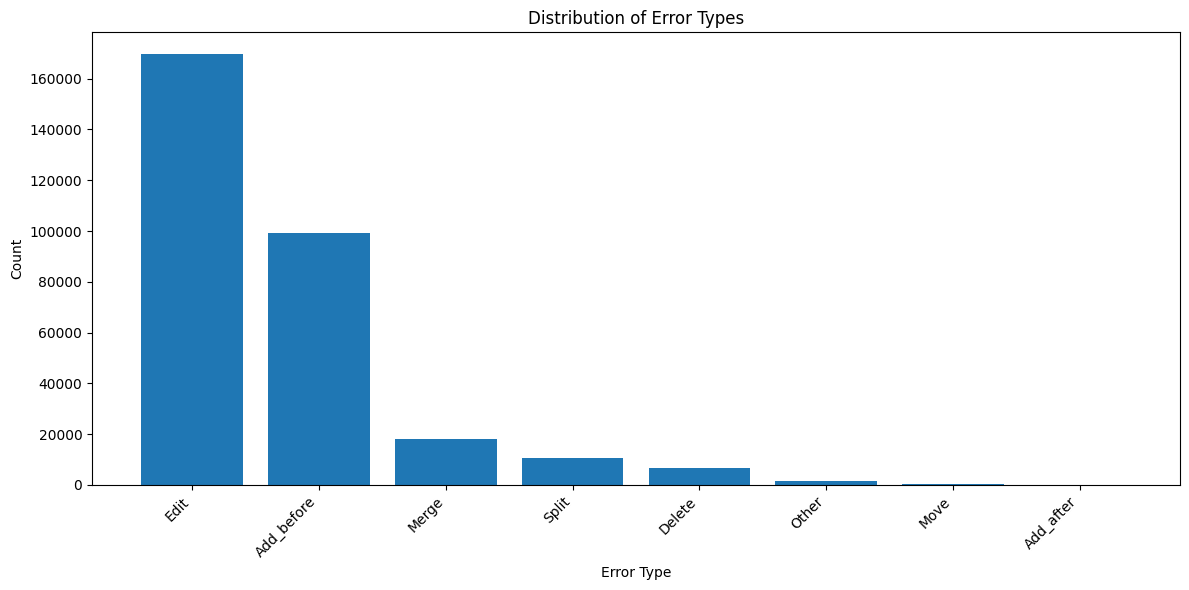

In [ ]:
# Get the error type counts
error_counts = Counter([et for row in df['edit_types'] for et in row]).most_common()

# Extract labels and values for plotting
labels = [item[0] for item in error_counts]
values = [item[1] for item in error_counts]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Distribution of Error Types')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

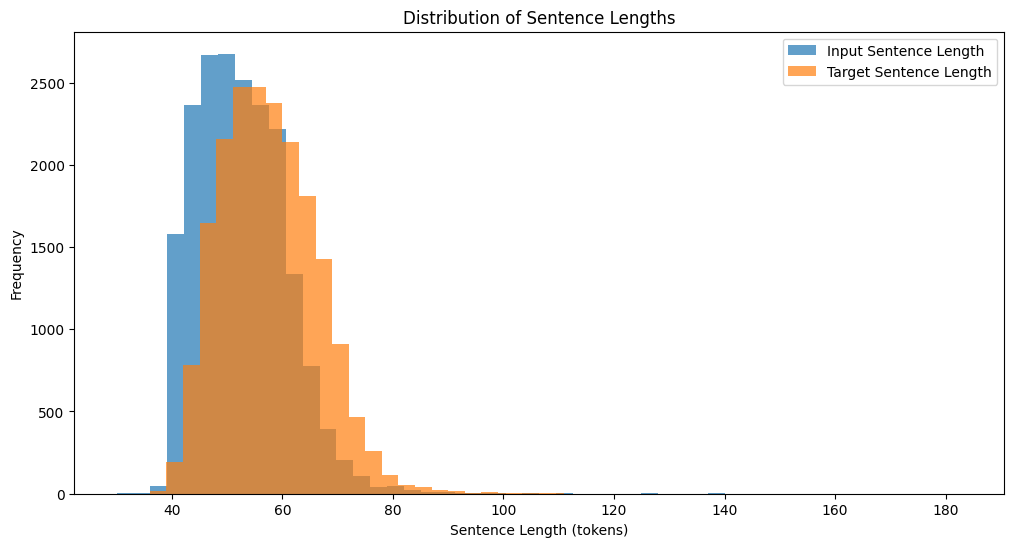

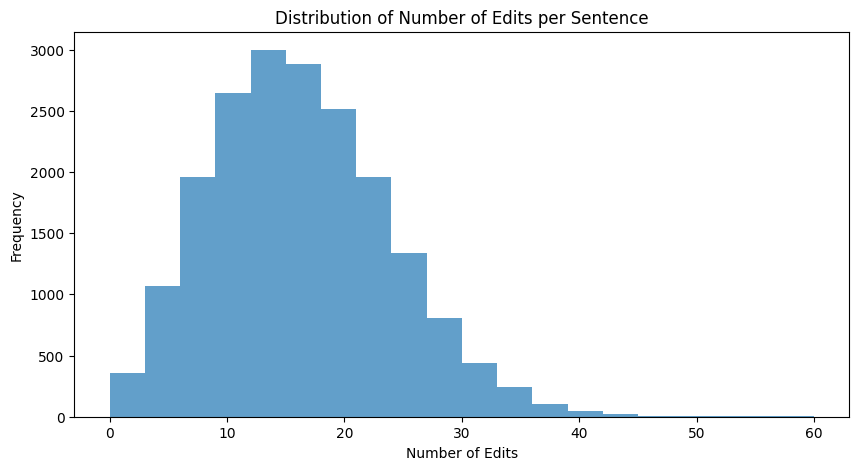

In [ ]:
# Calculate sentence lengths
df['input_length'] = df['input'].apply(lambda x: len(x.split()))
df['target_length'] = df['target'].apply(lambda x: len(x.split()))

# Plot distribution of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(df['input_length'], bins=50, alpha=0.7, label='Input Sentence Length')
plt.hist(df['target_length'], bins=50, alpha=0.7, label='Target Sentence Length')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()

# Plot distribution of the number of edits per sentence
plt.figure(figsize=(10, 5))
plt.hist(df['edit_count'], bins=20, alpha=0.7)
plt.xlabel('Number of Edits')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Edits per Sentence')
plt.show()

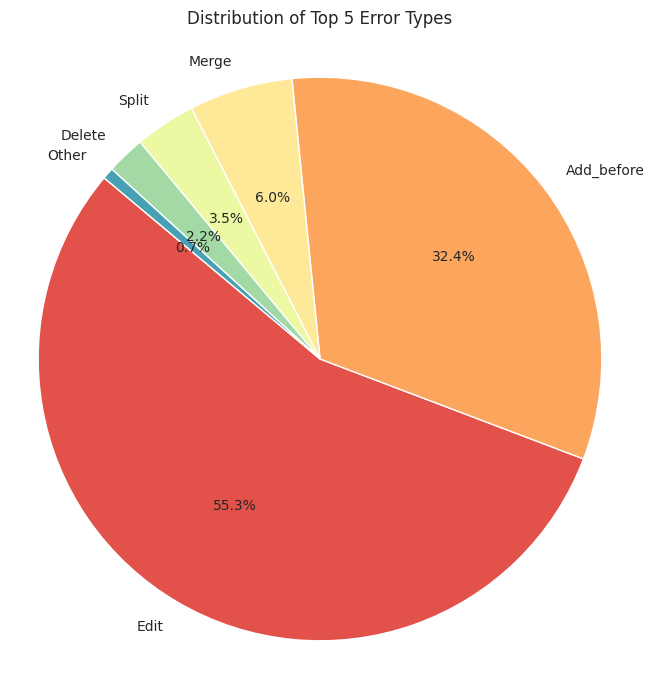

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Often provides nicer default styles and palettes

# Ensure seaborn is installed
try:
    import seaborn as sns
except ImportError:
    !pip install seaborn -q
    import seaborn as sns

# Get the top 5 error types
top_n = 5
top_error_counts = Counter([et for row in df['edit_types'] for et in row]).most_common(top_n)

# Calculate the counts for 'Other' errors
other_count = sum([count for error_type, count in Counter([et for row in df['edit_types'] for et in row]).items() if error_type not in [item[0] for item in top_error_counts]])

# Prepare data for the pie chart
labels = [item[0] for item in top_error_counts]
sizes = [item[1] for item in top_error_counts]

# Add 'Other' if there are more than top_n types
if other_count > 0:
    labels.append('Other')
    sizes.append(other_count)

# Set a nice style
sns.set_style("whitegrid")

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Spectral', len(labels)))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Top 5 Error Types', pad=20) # Add some padding to the title
plt.show()


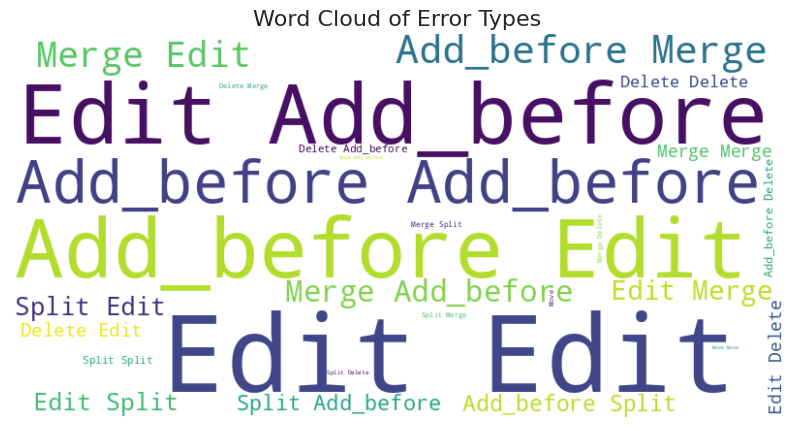

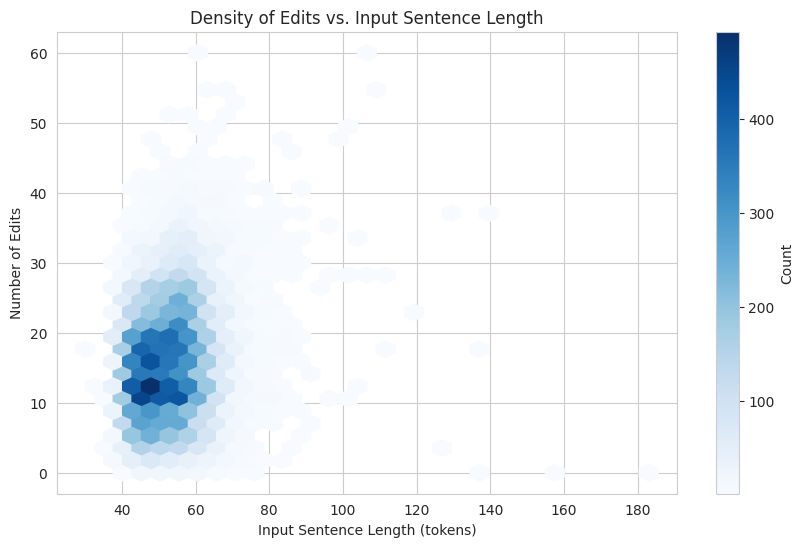

<ipython-input-17-5c96f354b2ba>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='input_length_bucket', y='edit_count', data=df_vis, inner='quartile', palette='viridis')


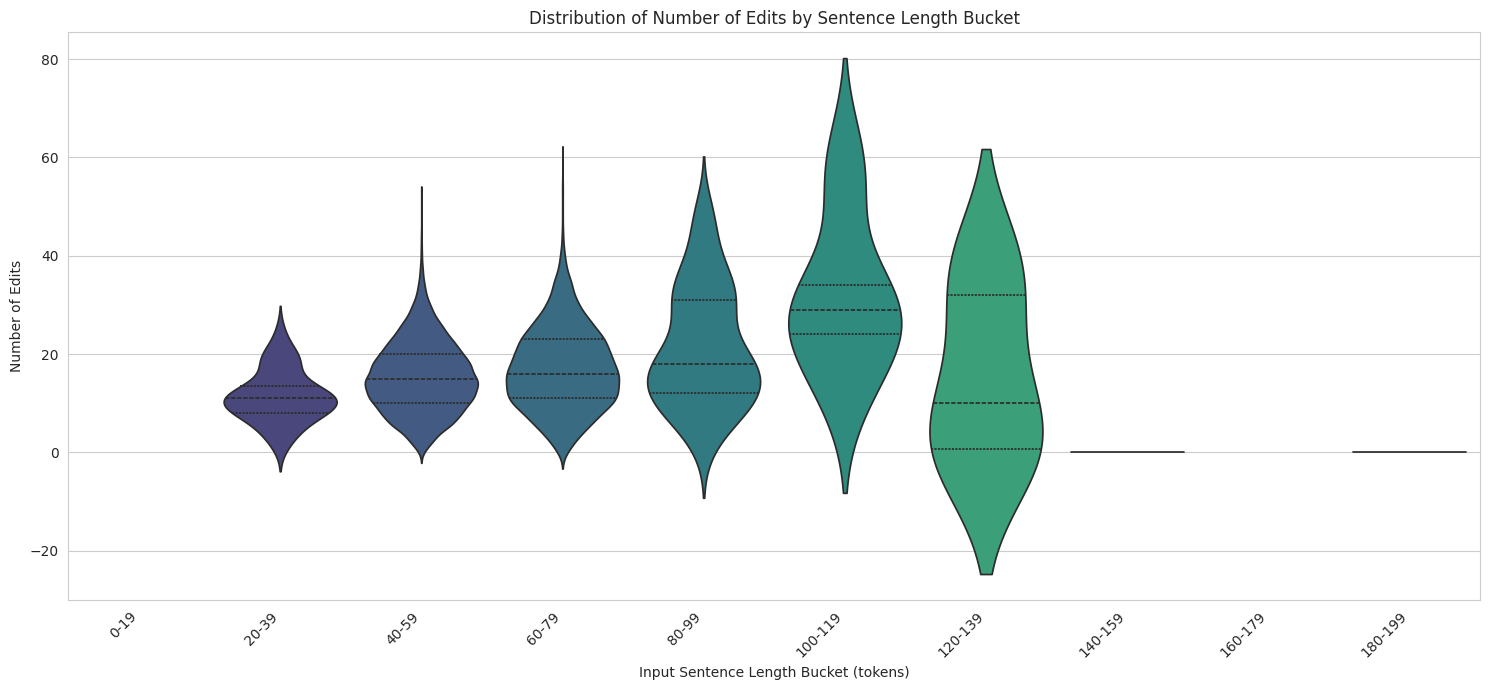

<ipython-input-17-5c96f354b2ba>:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_type_by_bucket = df_exploded_errors.groupby(['input_length_bucket', 'top_error_types']).size().unstack(fill_value=0)


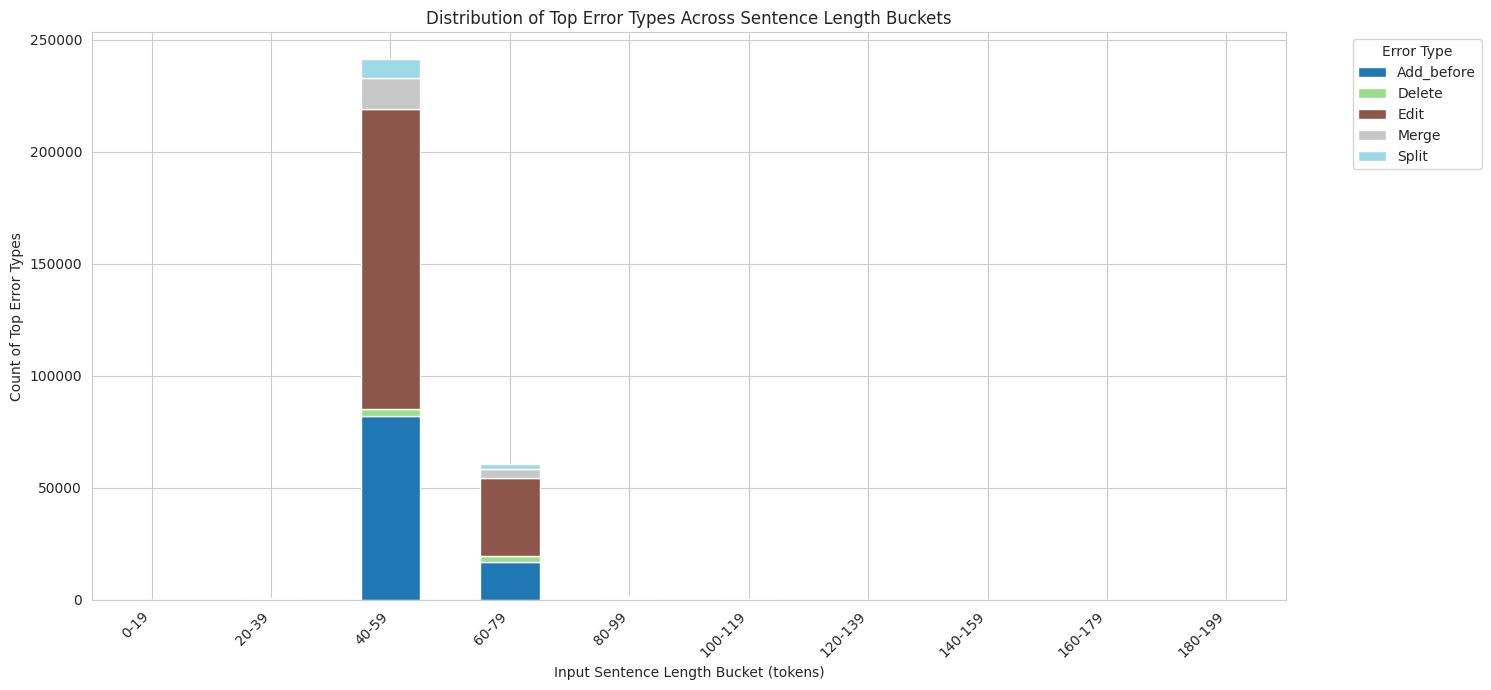

In [ ]:
# Creative Visualization: Word Cloud of Most Frequent Error Types

# Ensure wordcloud is installed
try:
    from wordcloud import WordCloud
except ImportError:
    !pip install wordcloud -q
    from wordcloud import WordCloud

# Get all error types from the dataframe
all_error_types = [et for row in df['edit_types'] for et in row]

# Create a single string of all error types, separated by spaces
error_types_text = " ".join(all_error_types)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(error_types_text)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Error Types', fontsize=16)
plt.show()

# Creative Visualization: Relationship between Sentence Length and Number of Edits (Scatter Plot with Hexbin)

# Use hexbin for better visualization of density
plt.figure(figsize=(10, 6))
hb = plt.hexbin(df['input_length'], df['edit_count'], gridsize=30, cmap='Blues', mincnt=1)
plt.colorbar(hb, label='Count')
plt.xlabel('Input Sentence Length (tokens)')
plt.ylabel('Number of Edits')
plt.title('Density of Edits vs. Input Sentence Length')
plt.show()

# Creative Visualization: Violin Plot of Number of Edits by Sentence Length Buckets

# Create buckets for sentence length
df['input_length_bucket'] = pd.cut(df['input_length'], bins=np.arange(0, df['input_length'].max() + 20, 20), right=False, labels=[f'{i}-{i+19}' for i in np.arange(0, df['input_length'].max(), 20)])

# Drop rows where bucket couldn't be assigned (e.g., very long sentences exceeding the last bucket)
df_vis = df.dropna(subset=['input_length_bucket'])

# Ensure there are enough data points in each bucket for a violin plot
if len(df_vis) > 0 and df_vis['input_length_bucket'].nunique() > 1:
    plt.figure(figsize=(15, 7))
    sns.violinplot(x='input_length_bucket', y='edit_count', data=df_vis, inner='quartile', palette='viridis')
    plt.xlabel('Input Sentence Length Bucket (tokens)')
    plt.ylabel('Number of Edits')
    plt.title('Distribution of Number of Edits by Sentence Length Bucket')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough variation in sentence lengths to create a meaningful violin plot by buckets.")


# Creative Visualization: Stacked Bar Chart of Top Error Types by Sentence Length Buckets (if meaningful)

# Get the top N error types again (excluding 'noop' if not desired for this analysis)
top_n_errors = Counter([et for row in df['edit_types'] for et in row if et != 'noop']).most_common(5)
top_error_list = [item[0] for item in top_n_errors]

# Filter dataframe to include only top error types
df_top_errors = df_vis.copy() # Use the dataframe with length buckets
df_top_errors['top_error_types'] = df_top_errors['edit_types'].apply(lambda error_list: [e for e in error_list if e in top_error_list])

# Explode the list of errors into multiple rows for easier counting
df_exploded_errors = df_top_errors.explode('top_error_types')

# Count occurrences of each top error type within each length bucket
error_type_by_bucket = df_exploded_errors.groupby(['input_length_bucket', 'top_error_types']).size().unstack(fill_value=0)

# Plot the stacked bar chart
if not error_type_by_bucket.empty:
    error_type_by_bucket.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='tab20')
    plt.xlabel('Input Sentence Length Bucket (tokens)')
    plt.ylabel('Count of Top Error Types')
    plt.title('Distribution of Top Error Types Across Sentence Length Buckets')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data or top error types to create a stacked bar chart by sentence length buckets.")



In [ ]:
df_copy = df.copy()

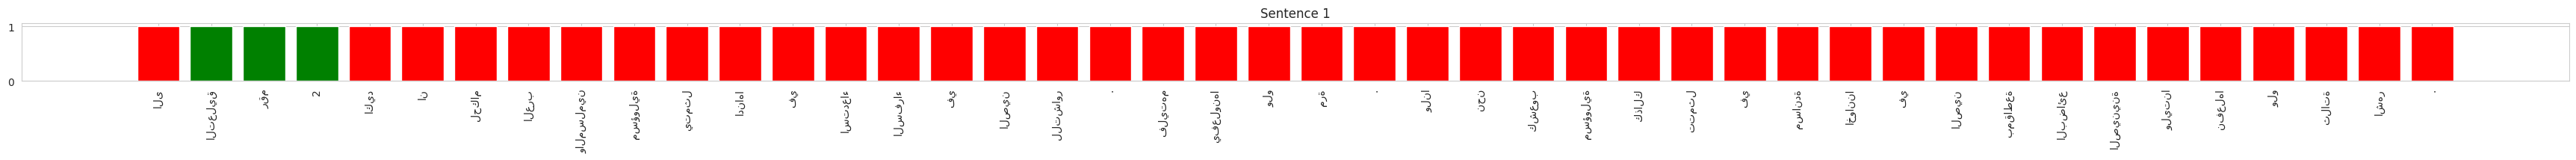

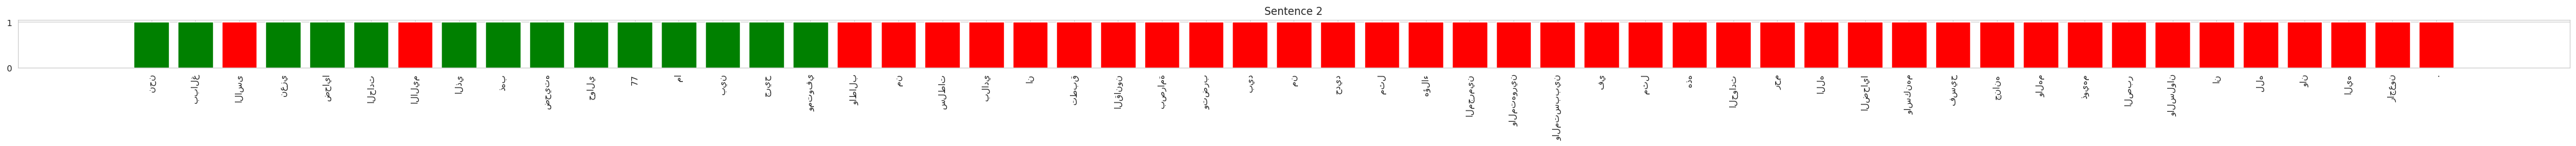

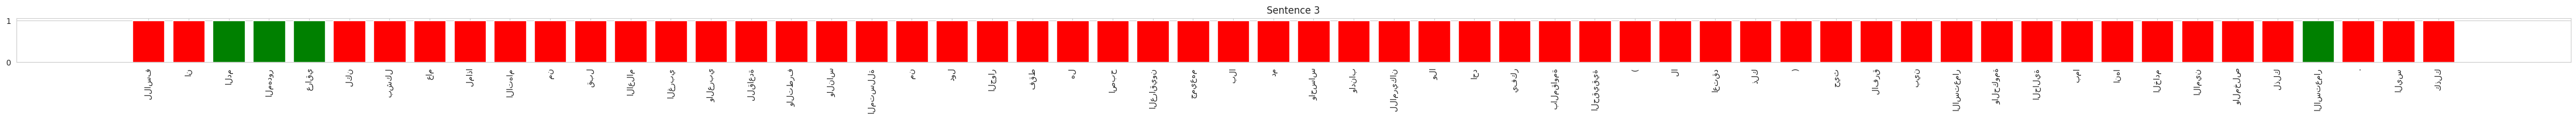

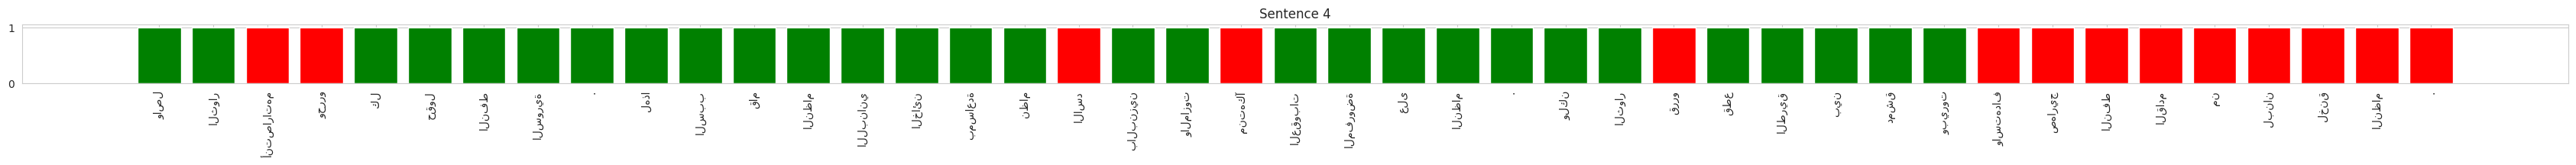

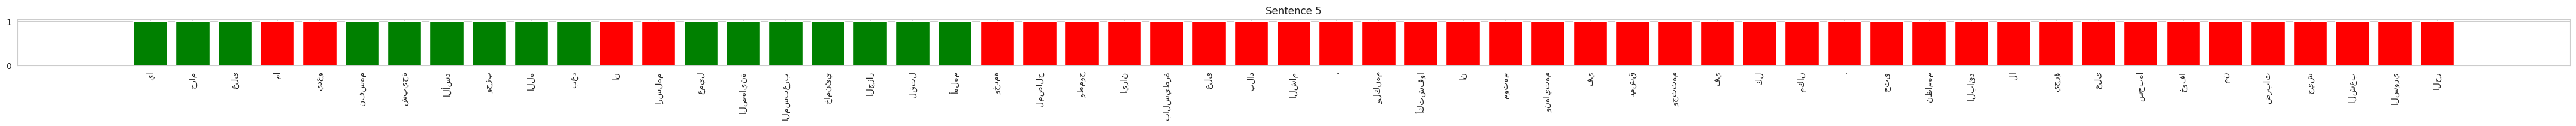

In [ ]:
# simplified version
import matplotlib.pyplot as plt

for idx, row in df_copy.head(5).iterrows():
    words = row['input'].split()
    correct = row['target'].split()
    colors = ['red' if w1 != w2 else 'green' for w1, w2 in zip(words, correct)]
    plt.figure(figsize=(len(words), 1))
    plt.bar(range(len(words)), [1]*len(words), color=colors)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title(f"Sentence {idx+1}")
    plt.show()


In [ ]:
#delete first 13k row

# df = df.iloc[13000:]

In [ ]:
df = df.sort_values(by='edit_count', ascending=True)

In [ ]:
df_model = df[['input', 'target']]

In [ ]:
import re

import re

def clean_text(sent):
    # Remove Latin letters
    sent = re.sub(r'[a-zA-Z]', '', sent)

    # Remove symbols, math, formatting, and Western punctuation EXCEPT Arabic ones
    sent = re.sub(r'[ـ\-\(\)\*/&_%؛@ٱ٪\[\]=^{}\\$`~|\'\"\n\r\t]', '', sent)

    # Remove diacritics (Tashkeel)
    sent = re.sub(r'[ًٌٍُِّْ]', '', sent)

    # Normalize space (optional)
    sent = re.sub(r'\s+', ' ', sent).strip()

    return sent

df_model['input'] = df_model['input'].apply(clean_text)
df_model['target'] = df_model['target'].apply(clean_text)
df = df_model

<ipython-input-23-94c874a4c51a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['input'] = df_model['input'].apply(clean_text)
<ipython-input-23-94c874a4c51a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['target'] = df_model['target'].apply(clean_text)


In [ ]:

# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

# encoding = tokenizer("هاذا الجمله فيهه خطاء.", max_length=128, padding='max_length', truncation=True)


In [ ]:
def preprocess(example):
    model_input = tokenizer(
        example['input'],
        max_length=128,
        padding='max_length',
        truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example['target'],
            max_length=128,
            padding='max_length',
            truncation=True
        )
    model_input['labels'] = labels['input_ids']
    return model_input


In [ ]:

import torch
print(torch.__version__)


2.6.0+cu124


In [ ]:
import torch
print(torch.cuda.is_available())         # Should return True
print(torch.cuda.get_device_name(0))     # Shows your current GPU (e.g., T4, V100)


True
Tesla T4


#Check for class imbalance



In [ ]:
df['label'] = (df['input'] != df['target']).astype(int)

<ipython-input-28-e8369d2d7138>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = (df['input'] != df['target']).astype(int)


In [ ]:
df.head(10)

,input,target,label
9020,لا وجود لأي مساحات أو احتمالات تجربة وانتظار أ...,لا وجود لأي مساحات أو احتمالات تجربة وانتظار أ...,0
7559,لقد حزم محمود درويش ، حقيبة الضوء ورحل . . وغز...,لقد حزم محمود درويش ، حقيبة الضوء ورحل . . وغز...,0
9726,تحية إجلال وإكبار لهذين الرجلين . . حقا إن إير...,تحية إجلال وإكبار لهذين الرجلين . . حقا إن إير...,0
7626,السلام عليكم . لقد عشت وزوجتي في السعودية فترة...,السلام عليكم . لقد عشت وزوجتي في السعودية فترة...,0
15910,لقد كانت في تونس وبعدها مصر وليبيا واليمن والآ...,لقد كانت في تونس وبعدها مصر وليبيا واليمن والآ...,0
19195,ما يرتعد منه الأسد هو أن ينجح العالم الخارجي ب...,ما يرتعد منه الأسد هو أن ينجح العالم الخارجي ب...,0
10445,أحب أن أوضح أن جيفارا ألحد بالكنيسة كما فعل كث...,أحب أن أوضح أن جيفارا ألحد بالكنيسة كما فعل كث...,0
11387,لأن الإسلام نظام شامل يتناول مظاهر الحياة جميع...,لأن الإسلام نظام شامل يتناول مظاهر الحياة جميع...,0
15832,مشكلة الأحزاب الإسلامية هي غياب الحوار الحر وت...,مشكلة الأحزاب الإسلامية هي غياب الحوار الحر وت...,0
13713,الكاتب أبدع في توضيح حقيقة الدولة المدنية التي...,الكاتب أبدع في توضيح حقيقة الدولة المدنية التي...,0


In [ ]:
# Frequency
print(df['label'].value_counts())

# Percentages
print(df['label'].value_counts(normalize=True) * 100)


label
1    19359
0       52
Name: count, dtype: int64
label
1    99.732111
0     0.267889
Name: proportion, dtype: float64


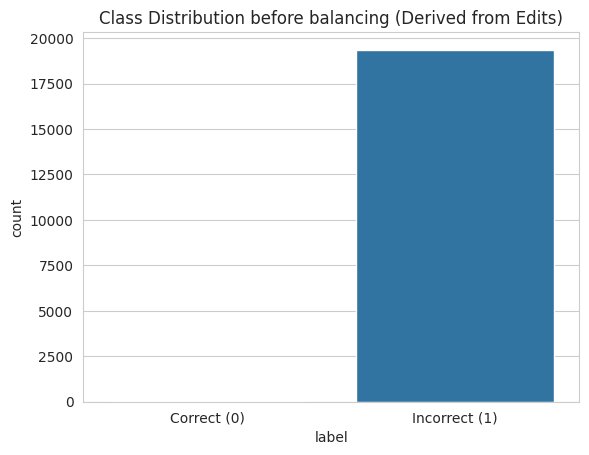

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.xticks([0, 1], ['Correct (0)', 'Incorrect (1)'])
plt.title('Class Distribution before balancing (Derived from Edits)')
plt.show()


In [ ]:
df.shape

(19411, 3)

In [ ]:
n = 5000 #Size that will be divided for each class

In [ ]:
# Sample 2500 incorrect ones
incorrect_samples = df[df['input'] != df['target']].sample(n=2500, random_state=42)

# Sample 2500 manually corrected sentences
correct_samples = df.sample(n=2500, random_state=42).copy()

In [ ]:
df_correct = correct_samples.copy()
df_correct['label'] = 0
df_correct['input'] = df_correct['target']

df_incorrect = incorrect_samples.copy()
df_incorrect['label'] = 1

df_balanced = pd.concat([df_correct, df_incorrect]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['label'].value_counts())
# Should return 2500 for each class


label
0    2500
1    2500
Name: count, dtype: int64


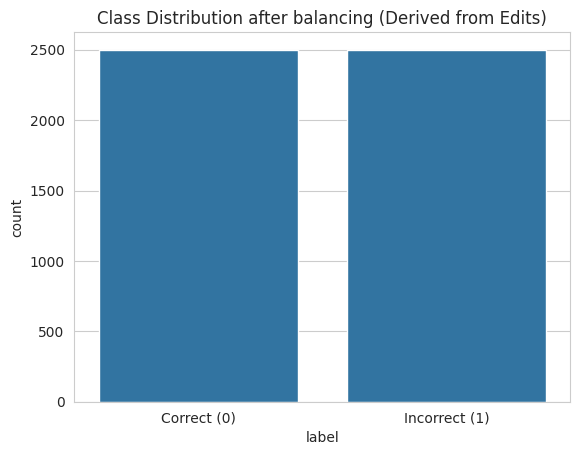

In [ ]:
sns.countplot(x='label', data=df_balanced)
plt.xticks([0, 1], ['Correct (0)', 'Incorrect (1)'])
plt.title('Class Distribution after balancing (Derived from Edits)')
plt.show()

In [ ]:
df_balanced = pd.concat([df_correct, df_incorrect]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(df_balanced['label'].value_counts())

label
0    2500
1    2500
Name: count, dtype: int64


In [ ]:
df_balanced.head(15)

,input,target,label
0,إلى محمد العلي من العراق : لا نقول إن الله أعر...,إلى محمد العلي من العراق : لا نقول إن الله أعر...,0
1,نعم لا بد من العصيان المدني وشل البلد كل البلد...,نعم لابد بد من العصيان المدني ، وشل البلد ، كل...,1
2,ماهذا الهراء ومن هولاء العلماء الذين يحرمون ال...,ما هذا الهراء ! ومن هؤلاء العلماء الذين يحرمون...,1
3,وحلب يا جزيرة ، نرجوا أن تنتبهوا إلى ذلك وأن و...,وحلب يا جزيرة ، نرجوا أن تنتبهوا إلى ذلك وأن و...,0
4,إسرائيل تمتلك رؤوسا نووية ولكن لا تظهرها وكذلك...,إسرائيل تمتلك رؤوسا نووية ولكن لا تظهرها وكذلك...,0
5,بالله عليك يا جزيرة كيف تسمحين لهؤلاء الوحوش ب...,بالله عليك يا جزيرة كيف تسمحين لهؤلاء الوحوش ب...,0
6,والله هو يعرف نفسه أنه كذب ولا يستطيع أصلا وقف...,والله هو يعرف نفسه أنه كذب ولا يستطيع أصلا وقف...,0
7,يعني اللي بيسمع مش زي اللي بيشوف أنا انا اللي ...,يعني اللي بيسمع مش زي اللي بيشوف أنا انا اللي ...,0
8,خسئتم أيها الرجعيون ، نحن لن نضل الطريق لأن لن...,خسئتم أيها الرجعيون ، نحن لن نضل الطريق لأن لن...,0
9,الرياضة في بلادنا ليست من أجل الصحة والتعارف و...,الرياضة في بلادنا ليست من أجل الصحة والتعارف و...,0


In [ ]:
df = df_balanced

#Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

y = (df['input'] != df['target']).astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['input'], y, test_size=0.2, random_state=42
)


vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=10000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_nb = nb.predict(X_test)

print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


[[453  23]
 [152 372]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       476
           1       0.94      0.71      0.81       524

    accuracy                           0.82      1000
   macro avg       0.85      0.83      0.82      1000
weighted avg       0.85      0.82      0.82      1000



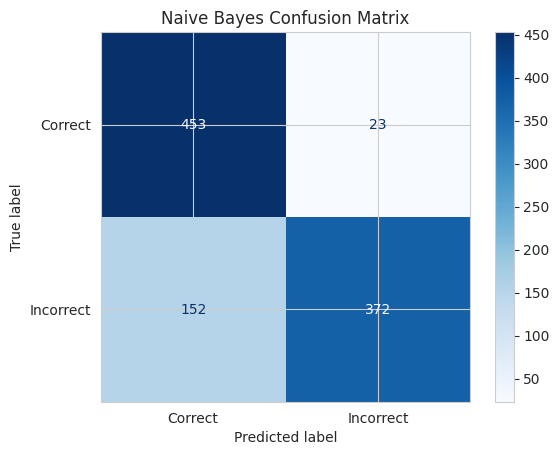

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, display_labels=["Correct", "Incorrect"], cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Get predicted probabilities for class 1
y_proba = nb.predict_proba(X_test)[:, 1]

# Range of thresholds to evaluate
thresholds = np.arange(0.1, 0.91, 0.01)

# Store results
scores = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    scores.append((t, precision, recall, f1))

# Find best threshold
best = max(scores, key=lambda x: x[3])  # sort by F1

print(f"🔍 Best Threshold: {best[0]:.2f}")
print(f"🎯 Precision: {best[1]:.3f} | Recall: {best[2]:.3f} | F1 Score: {best[3]:.3f}")


🔍 Best Threshold: 0.42
🎯 Precision: 0.868 | Recall: 0.777 | F1 Score: 0.820


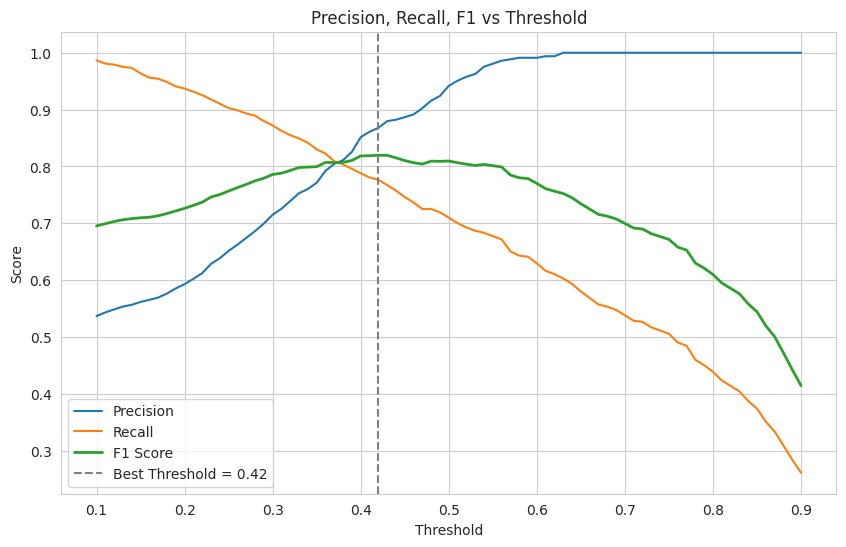

In [ ]:
import matplotlib.pyplot as plt

thresholds = [s[0] for s in scores]
precisions = [s[1] for s in scores]
recalls = [s[2] for s in scores]
f1s = [s[3] for s in scores]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score', linewidth=2)
plt.axvline(best[0], color='gray', linestyle='--', label=f'Best Threshold = {best[0]:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
probs = nb.predict_proba(vectorizer.transform(["هاذا الجمله فيهه خطاء."]))
print("Probabilities:", probs)


Probabilities: [[0.38872315 0.61127685]]


In [ ]:
test_sentences = [
    "هذا نص صحيح ومتكامل.",
    "هاذا الجمله فيهه خطاء.",
    "أحب البرمجة والتعلم الذاتي.",
    "كتابت الجمله غيير صحيحه."
]

X_custom = vectorizer.transform(test_sentences)
probs = nb.predict_proba(X_custom)
preds = (probs[:, 1] > 0.42).astype(int)

for sent, prob, pred in zip(test_sentences, probs[:, 1], preds):
    print(f"❓ Sentence: {sent}")
    print(f"🧠 Confidence it's incorrect: {prob:.2f}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")
    print("―" * 50)


❓ Sentence: هذا نص صحيح ومتكامل.
🧠 Confidence it's incorrect: 0.47
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: هاذا الجمله فيهه خطاء.
🧠 Confidence it's incorrect: 0.61
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: أحب البرمجة والتعلم الذاتي.
🧠 Confidence it's incorrect: 0.39
✅ Correct
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: كتابت الجمله غيير صحيحه.
🧠 Confidence it's incorrect: 0.43
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――


#SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Label: 1 = incorrect, 0 = correct
y = (df['input'] != df['target']).astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['input'], y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=10000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

In [ ]:
svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

In [ ]:
from sklearn.metrics import f1_score

probs = svm.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.01)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    preds = (probs >= 0.7).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = t

print(f"✅ Best threshold: {best_threshold:.2f}, F1 Score: {best_f1:.3f}")

✅ Best threshold: 0.54, F1 Score: 0.878


In [ ]:
test_sentences = [
    "هذا نص صحيح ومتكامل.",
    "هاذا الجمله فيهه خطاء.",
    "الذكاء الاصطناعي ممتع.",
    "كتابت الجمله غيير صحيحه."
]

X_custom = vectorizer.transform(test_sentences)
custom_probs = svm.predict_proba(X_custom)[:, 1]
custom_preds = (custom_probs >= best_threshold).astype(int)

for sent, prob, pred in zip(test_sentences, custom_probs, custom_preds):
    print(f"❓ Sentence: {sent}")
    print(f"🧠 Error Probability: {prob:.2f}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")
    print("―" * 50)


❓ Sentence: هذا نص صحيح ومتكامل.
🧠 Error Probability: 0.86
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: هاذا الجمله فيهه خطاء.
🧠 Error Probability: 0.78
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: الذكاء الاصطناعي ممتع.
🧠 Error Probability: 0.98
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: كتابت الجمله غيير صحيحه.
🧠 Error Probability: 0.58
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――


#XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y = (df['input'] != df['target']).astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(df['input'], y, test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(analyzer='char',max_features=5000, ngram_range=(2, 5))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       476
           1       0.92      0.90      0.91       524

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



Confusion Matrix:


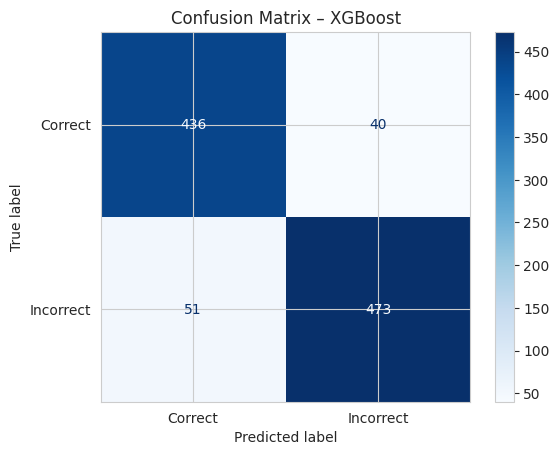

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Correct", "Incorrect"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – XGBoost")
plt.show()

In [ ]:
# 1. Define random test sentences
test_sentences = [
    "هذا نص صحيح ومتكامل.",
    "هاذا الجمله فيهه خطاء.",
    "الذكاء الاصطناعي ممتع.",
    "كتابت الجمله غيير صحيحه."
]

# 2. Transform using the same vectorizer
X_random = vectorizer.transform(test_sentences)

# 3. Predict using the trained XGBoost model
probs = xgb_model.predict_proba(X_random)[:, 1]  # Probability of class 1 (Has Error)
preds = (probs > 0.5).astype(int)

# 4. Display Results
for i, sentence in enumerate(test_sentences):
    print("❓ Sentence:", sentence)
    print("🧠 Error Probability:", round(probs[i], 2))
    print("✅ No Error" if preds[i] == 0 else "❌ Has Error")
    print("―" * 60)


❓ Sentence: هذا نص صحيح ومتكامل.
🧠 Error Probability: 0.99
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: هاذا الجمله فيهه خطاء.
🧠 Error Probability: 1.0
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: الذكاء الاصطناعي ممتع.
🧠 Error Probability: 1.0
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: كتابت الجمله غيير صحيحه.
🧠 Error Probability: 0.99
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [ ]:
for sentence in test_sentences:
    vector = vectorizer.transform([sentence])
    print(f"Non-zero features in '{sentence}':", vector.nnz)


Non-zero features in 'هذا نص صحيح ومتكامل.': 28
Non-zero features in 'هاذا الجمله فيهه خطاء.': 40
Non-zero features in 'الذكاء الاصطناعي ممتع.': 31
Non-zero features in 'كتابت الجمله غيير صحيحه.': 36


In [ ]:
for s in test_sentences:
    v = vectorizer.transform([s])
    print(s, "→ nnz:", v.nnz)


هذا نص صحيح ومتكامل. → nnz: 28
هاذا الجمله فيهه خطاء. → nnz: 40
الذكاء الاصطناعي ممتع. → nnz: 31
كتابت الجمله غيير صحيحه. → nnz: 36


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=15, weights='distance')

In [ ]:
y_pred_knn = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


[[360 116]
 [193 331]]
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       476
           1       0.74      0.63      0.68       524

    accuracy                           0.69      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.69      0.69      1000



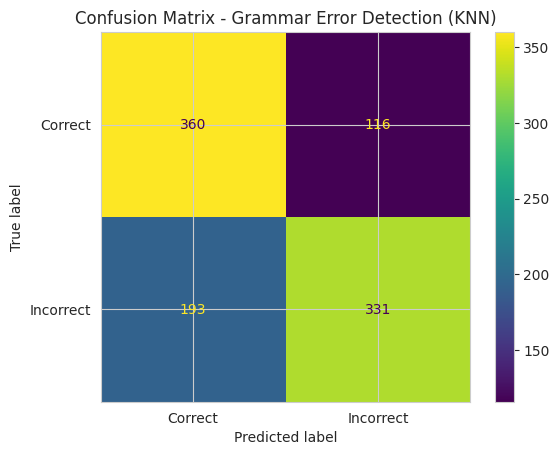

In [ ]:
# Make predictions using the KNN model
y_pred_knn = knn.predict(X_test)

# Visualize the confusion matrix for KNN
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_knn,
    display_labels=["Correct", "Incorrect"],
    cmap="viridis" # Using a different colormap for variety
)
plt.title("Confusion Matrix - Grammar Error Detection (KNN)")
plt.show()

In [ ]:
test_sentences = [
    "الطلاب يذهبون إلى المدرسة كل صباح.",
    "طلاب يذهبو الى مدرسه كل صبااح."
]

X_test_custom = vectorizer.transform(test_sentences)
preds = knn.predict(X_test_custom)

for sent, pred in zip(test_sentences, preds):
    print(f"❓ Sentence: {sent}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")


❓ Sentence: الطلاب يذهبون إلى المدرسة كل صباح.
✅ Correct
❓ Sentence: طلاب يذهبو الى مدرسه كل صبااح.
❌ Has Error


In [ ]:
for k in range(3, 16, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    print(f"K={k}, Accuracy: {knn.score(X_test, y_test):.4f}")


K=3, Accuracy: 0.6070
K=5, Accuracy: 0.6390
K=7, Accuracy: 0.6640
K=9, Accuracy: 0.6610
K=11, Accuracy: 0.6710
K=13, Accuracy: 0.6820
K=15, Accuracy: 0.6980


#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion

y = (df['input'] != df['target']).astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['input'], y, test_size=0.2, random_state=42, stratify=y
)

char_vect = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=3000)
word_vect = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=2000)

vectorizer = FeatureUnion([("word", word_vect), ("char", char_vect)])

X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,                # limit tree depth
    min_samples_leaf=5,          # force generalization
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, n_jobs=-1, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       500
           1       0.97      0.77      0.86       500

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.87      1000
weighted avg       0.89      0.88      0.87      1000



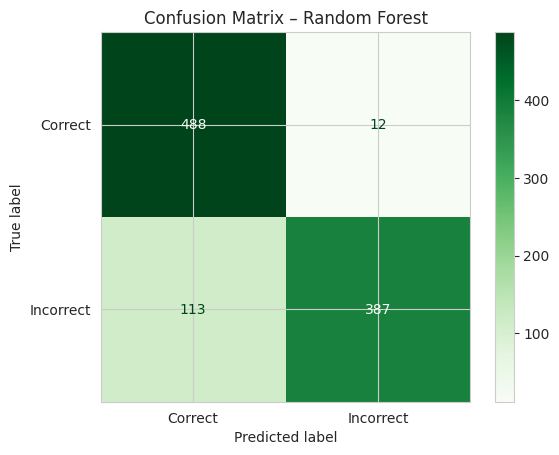

In [ ]:
y_pred_rf = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=["Correct", "Incorrect"], cmap="Greens"
)
plt.title("Confusion Matrix – Random Forest")
plt.show()


In [ ]:
probs_rf = rf_model.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_f1 = 0

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs_rf >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"✅ Best Threshold: {best_threshold:.2f} | Best F1 Score: {best_f1:.3f}")


✅ Best Threshold: 0.40 | Best F1 Score: 0.894


In [ ]:
test_sentences = [
    "هذا نص صحيح ومتكامل.",
    "هاذا الجمله فيهه خطاء.",
    "الذكاء الاصطناعي ممتع.",
    "كتابت الجمله غيير صحيحه."
]

X_custom = vectorizer.transform(test_sentences)
probs_custom = rf_model.predict_proba(X_custom)[:, 1]
custom_preds = (probs_custom >= 0.65).astype(int)

for sent, prob, pred in zip(test_sentences, probs_custom, custom_preds):
    print(f"❓ Sentence: {sent}")
    print(f"🧠 Error Probability: {prob:.2f}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")
    print("―" * 60)


❓ Sentence: هذا نص صحيح ومتكامل.
🧠 Error Probability: 0.62
✅ Correct
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: هاذا الجمله فيهه خطاء.
🧠 Error Probability: 0.63
✅ Correct
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: الذكاء الاصطناعي ممتع.
🧠 Error Probability: 0.80
❌ Has Error
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
❓ Sentence: كتابت الجمله غيير صحيحه.
🧠 Error Probability: 0.63
✅ Correct
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


#Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# X = df['input'], y = (df['input'] != df['target']).astype(int)
y = (df['input'] != df['target']).astype(int)

X_train_text, X_test_text, y_train, y_test = train_test_split(df['input'], y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)




LogisticRegression(class_weight='balanced')

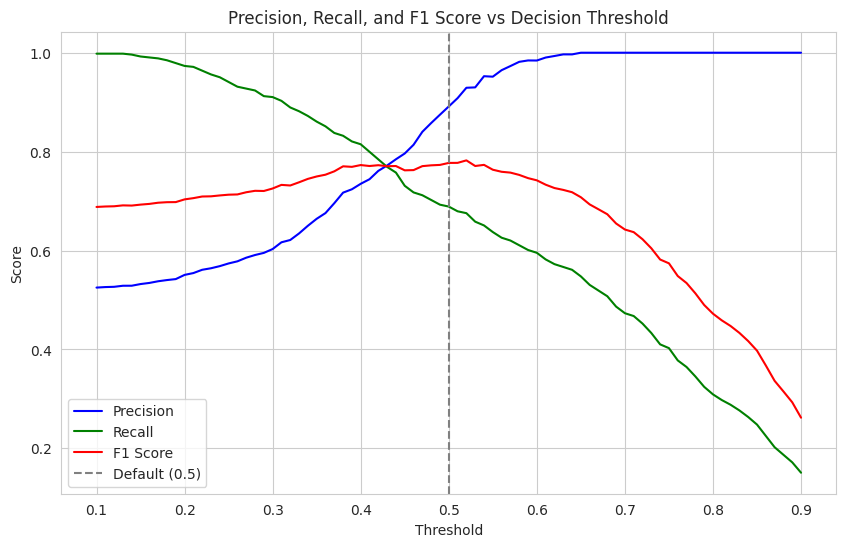

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Get probability predictions for class 1 (has error)
y_proba = model.predict_proba(X_test)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.91, 0.01)

# Store metrics
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1s, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Decision Threshold')
plt.axvline(0.5, color='gray', linestyle='--', label='Default (0.5)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Convert to numpy arrays
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

# Find best threshold by F1 score
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"🔍 Best Threshold by F1 Score: {best_threshold:.2f}")
print(f"📊 F1 Score at this threshold: {best_f1:.3f}")
print(f"🎯 Precision: {precisions[best_idx]:.3f} | Recall: {recalls[best_idx]:.3f}")


🔍 Best Threshold by F1 Score: 0.52
📊 F1 Score at this threshold: 0.782
🎯 Precision: 0.929 | Recall: 0.676


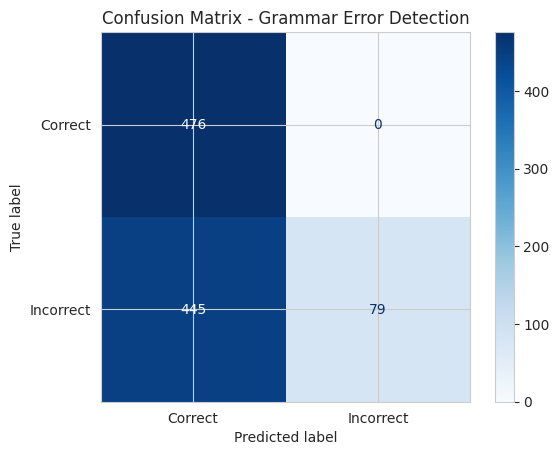

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_thresh,
    display_labels=["Correct", "Incorrect"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Grammar Error Detection")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (incorrect)
y_pred_custom = (y_proba > best_threshold).astype(int)  # Try 0.6 or 0.65

print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))



[[449  27]
 [170 354]]
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       476
           1       0.93      0.68      0.78       524

    accuracy                           0.80      1000
   macro avg       0.83      0.81      0.80      1000
weighted avg       0.83      0.80      0.80      1000



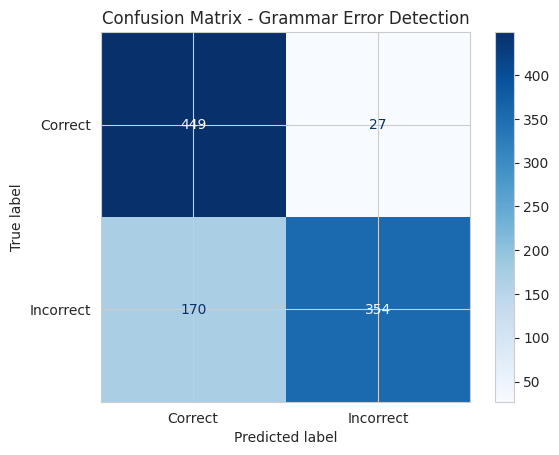

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_custom,
    display_labels=["Correct", "Incorrect"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Grammar Error Detection")
plt.show()


In [ ]:
test_sentences = [
    "الطلاب يذهبون إلى المدرسة كل صباح.", # Expected: 0 (Correct)
    "هاذا الجمله فيهه خطاء."   # should return 1 (incorrect)
]

X_custom = vectorizer.transform(test_sentences)
predictions = model.predict(X_custom)

for sent, pred in zip(test_sentences, predictions):
    print(f"❓ Sentence: {sent}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")


❓ Sentence: الطلاب يذهبون إلى المدرسة كل صباح.
✅ Correct
❓ Sentence: هاذا الجمله فيهه خطاء.
❌ Has Error


#MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # Two hidden layers
    activation='relu',              # Common for NLP
    solver='adam',                  # Adaptive gradient optimizer
    max_iter=200,                   # You can raise this if it doesn’t converge
    early_stopping=True,           # Prevent overfitting
    random_state=42
)

mlp.fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64),
              random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_mlp = mlp.predict(X_test)

print(confusion_matrix(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))


[[430  46]
 [178 346]]
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       476
           1       0.88      0.66      0.76       524

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.77      1000
weighted avg       0.80      0.78      0.77      1000



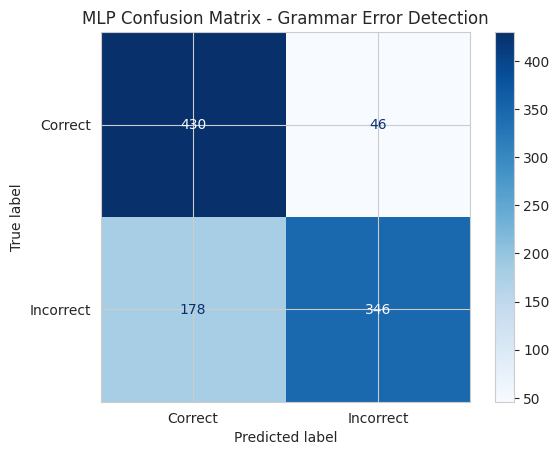

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_mlp,
    display_labels=["Correct", "Incorrect"],
    cmap="Blues",
    values_format='d'
)
plt.title("MLP Confusion Matrix - Grammar Error Detection")
plt.show()


In [ ]:
test_sentences = [
    "التكنولوجيا الحديثة تسهل الحياة اليومية.",               # ✅ Correct
    "هاذي الكلمه غيير صحيحه."                                # ❌ Has Error
    "الشمس تشرق من الشرق وتغرب في الغرب.",                   # ✅ Correct
    "كلمات لا تكون مفهومه تماما عند بعض ناس."                # ❌ Has Error
    "أنا أحب تعلم الذكاء الاصطناعي واستخدامه في المشاريع."    # ✅ Correct
]

X_custom = vectorizer.transform(test_sentences)
preds = mlp.predict(X_custom)

for sent, pred in zip(test_sentences, preds):
    print(f"❓ Sentence: {sent}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")


X_custom = vectorizer.transform(test_sentences)
preds = mlp.predict(X_custom)

for sent, pred in zip(test_sentences, preds):
    print(f"❓ Sentence: {sent}")
    print("✅ Correct" if pred == 0 else "❌ Has Error")


❓ Sentence: التكنولوجيا الحديثة تسهل الحياة اليومية.
❌ Has Error
❓ Sentence: هاذي الكلمه غيير صحيحه.الشمس تشرق من الشرق وتغرب في الغرب.
❌ Has Error
❓ Sentence: كلمات لا تكون مفهومه تماما عند بعض ناس.أنا أحب تعلم الذكاء الاصطناعي واستخدامه في المشاريع.
✅ Correct
❓ Sentence: التكنولوجيا الحديثة تسهل الحياة اليومية.
❌ Has Error
❓ Sentence: هاذي الكلمه غيير صحيحه.الشمس تشرق من الشرق وتغرب في الغرب.
❌ Has Error
❓ Sentence: كلمات لا تكون مفهومه تماما عند بعض ناس.أنا أحب تعلم الذكاء الاصطناعي واستخدامه في المشاريع.
✅ Correct
